# Exploration des données

## Import des bibliothèques

In [154]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency
import seaborn as sns
import io


## Chargement des données

In [155]:
X_test_full = pd.read_csv('./datas/X_test.csv')
y_test_full = pd.read_csv('./datas/Y_test.csv')

#Import des datas train
X_train_full = pd.read_csv('./datas/X_train.csv')
Y_train_full = pd.read_csv('./datas/y_train.csv')

 ## Nos Y

Autocorrélation de 'spot_id_delta' avec elle-même: 0.7107856450514393
Valeurs de la fonction d'autocorrélation (ACF):
[1.         0.71074701 0.47685964 0.40240408 0.33960978 0.30442121
 0.27829575 0.25328681 0.23024765 0.22021387 0.18443277 0.16772724
 0.14697851 0.11911646 0.10465129 0.09486627 0.08327889 0.07451282
 0.0649726  0.0489283  0.03842826 0.03846234 0.04162649 0.05365476
 0.05918062 0.04662237 0.0372881  0.02444906 0.01198338 0.00770723
 0.00662887 0.00497258 0.00935978 0.01682656 0.02434564 0.03376427
 0.0459359  0.04687686 0.04349781 0.04708764 0.0475077 ]


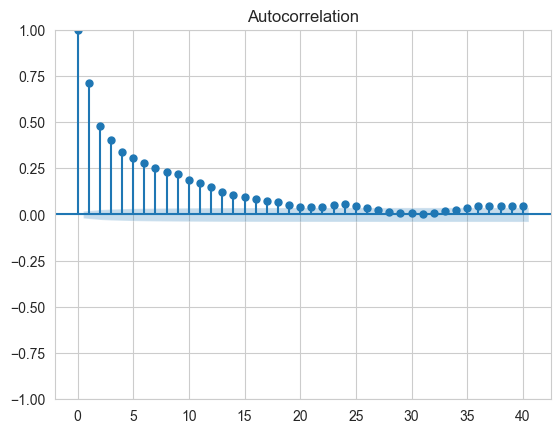

Résultats du test de Ljung-Box:
         lb_stat  lb_pvalue
10  14638.105284        0.0


In [156]:
y = Y_train_full

# Calcul de l'autocorrélation
autocorrelation = y['spot_id_delta'].autocorr()
print(f"Autocorrélation de 'spot_id_delta' avec elle-même: {autocorrelation}")

# Calcul et affichage de la fonction d'autocorrélation (ACF)
acf_values = sm.tsa.acf(y['spot_id_delta'], nlags=40)
print("Valeurs de la fonction d'autocorrélation (ACF):")
print(acf_values)

# Tracé de la fonction d'autocorrélation
plot_acf(y['spot_id_delta'], lags=40)
plt.show()

# Test de Ljung-Box pour vérifier l'autocorrélation
ljung_box_test = sm.stats.acorr_ljungbox(y['spot_id_delta'], lags=[10], return_df=True)
print("Résultats du test de Ljung-Box:")
print(ljung_box_test)

## Nos X

In [157]:
X_test_full.head()

,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nuclear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
0,2023-04-02 00:00:00+02:00,45814.0,3386.0,10902.0,36705.0,6359.0,0.0,56.764535,0.0,NaN
1,2023-04-02 01:00:00+02:00,44084.0,3386.0,10902.0,36705.0,6469.0,0.0,54.262133,0.0,NaN
2,2023-04-02 02:00:00+02:00,43281.0,3386.0,10902.0,36705.0,6511.0,0.0,78.105928,0.0,NaN
3,2023-04-02 03:00:00+02:00,40825.0,3386.0,10902.0,36705.0,6628.0,0.0,78.187557,0.0,NaN
4,2023-04-02 04:00:00+02:00,39181.0,3386.0,10902.0,36705.0,6700.0,0.0,96.765484,0.0,NaN


In [158]:
print(X_train_full.describe())


       load_forecast  coal_power_available  gas_power_available  \
count    9318.000000          10604.000000         10604.000000   
mean    53725.132968           2819.781592         11463.220671   
std     11274.194929            495.103588           483.799154   
min     30515.000000           1646.000000          9769.000000   
25%     45336.500000           2226.000000         11140.000000   
50%     51846.000000           2806.000000         11487.000000   
75%     62091.750000           3386.000000         11945.000000   
max     85145.000000           3391.000000         11963.000000   

       nuclear_power_available  wind_power_forecasts_average  \
count             10604.000000                  10581.000000   
mean              35393.282252                   4512.989415   
std                7619.820162                   3349.419356   
min               22285.000000                    592.000000   
25%               29005.000000                   2036.000000   
50%         

In [159]:
print(X_train_full.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10605 entries, 0 to 10604
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DELIVERY_START                 10605 non-null  object 
 1   load_forecast                  9318 non-null   float64
 2   coal_power_available           10604 non-null  float64
 3   gas_power_available            10604 non-null  float64
 4   nuclear_power_available        10604 non-null  float64
 5   wind_power_forecasts_average   10581 non-null  float64
 6   solar_power_forecasts_average  10581 non-null  float64
 7   wind_power_forecasts_std       10581 non-null  float64
 8   solar_power_forecasts_std      10581 non-null  float64
 9   predicted_spot_price           1846 non-null   float64
dtypes: float64(9), object(1)
memory usage: 828.6+ KB
None


### Matrice de corrélation

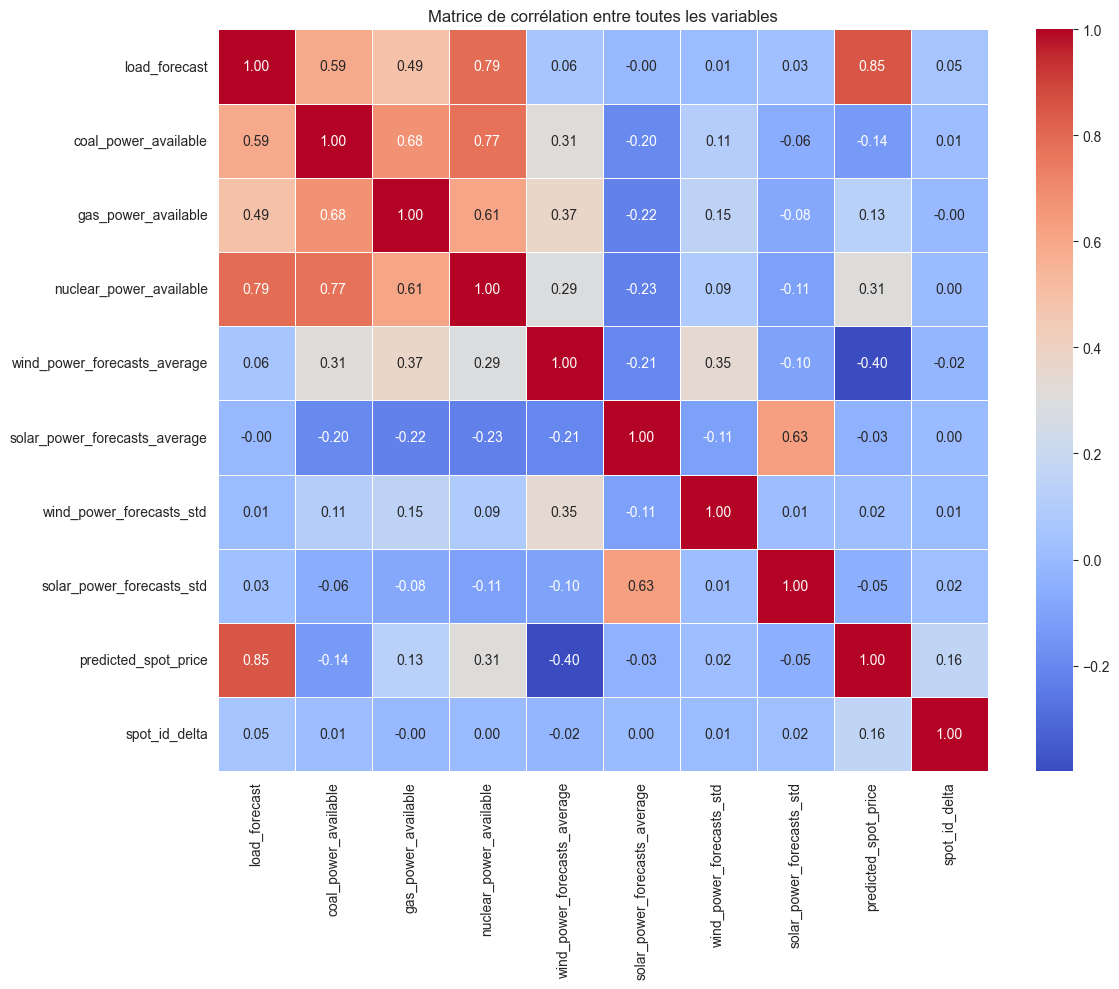

In [160]:
df_X_Y_merged = pd.merge(X_train_full, Y_train_full, on='DELIVERY_START')

correlation_matrix = df_X_Y_merged.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matrice de corrélation entre toutes les variables')
plt.tight_layout()
plt.show()

In [161]:
# load_forecast: Prévision de charge électrique (12% manquantes)
# coal_power_available: Capacité disponible des centrales à charbon
# gas_power_available: Capacité disponible des centrales à gaz
# nuclear_power_available: Capacité disponible des centrales nucléaires
#A noter ques coal, gas et nuclear sont en données journalières !!
# wind_power_forecasts_average: Prévision moyenne de production éolienne
# solar_power_forecasts_average: Prévision moyenne de production solaire (manquantes la nuit ~100% entre 23h-4h)
# wind_power_forecasts_std: Écart-type des prévisions de production éolienne
# solar_power_forecasts_std: Écart-type des prévisions de production solaire (manque quand solar_average manque)
# predicted_spot_price: Prix spot prévu (82% manquantes - probablement la variable à prédire)
#
# Note: Les valeurs manquantes pour solar_ s'expliquent par l'absence de production solaire la nuit. --> Pour ces colonnes, pas d'imputation prévu, mais il y a des Nan sur un jour

## Traitement des varaibles manquantes

### On concat le train et test df

In [162]:
X_train_full['data_source'] = 'train'
X_test_full['data_source'] = 'test'
df = pd.concat([X_train_full, X_test_full], axis=0, ignore_index=True)


### load_forcast imputation

In [163]:
df['hour'] = df['DELIVERY_START'].astype(str).str.extract(r'(\d{2}):\d{2}:\d{2}').astype(int)


df['hour'] = df['DELIVERY_START'].astype(str).str.extract(r'(\d{2}):\d{2}:\d{2}').astype(int)


#On fait des tests avec différentes méthodes
missing_mask = df['load_forecast'].isna()
print(f"Nombre de valeurs manquantes dans load_forecast: {missing_mask.sum()} sur {len(df)}")

# Créer un ensemble de test en masquant 10% des valeurs connues pour évaluation
df_complete = df[~missing_mask].copy()
np.random.seed(42)
n_samples = len(df_complete)
n_missing_test = int(n_samples * 0.1)
test_indices = np.random.choice(df_complete.index, n_missing_test, replace=False)

df_eval = df_complete.copy()
true_values = df_eval.loc[test_indices, 'load_forecast'].copy()
df_eval.loc[test_indices, 'load_forecast'] = np.nan

results = []

# Fonction pour évaluer l'imputation
def evaluate_method(imputed_values, true_values, method_name):
    mae = mean_absolute_error(true_values, imputed_values)
    rmse = np.sqrt(mean_squared_error(true_values, imputed_values))
    mape = np.mean(np.abs((true_values - imputed_values) / true_values)) * 100

    print(f"\n{method_name}:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")

    return {'method': method_name, 'mae': mae, 'rmse': rmse, 'mape': mape}

Nombre de valeurs manquantes dans load_forecast: 1287 sur 15547


In [164]:
# 1. Imputation par la moyenne globale
df_mean = df_eval.copy()
mean_imputer = SimpleImputer(strategy='mean')
df_mean['load_forecast'] = mean_imputer.fit_transform(df_mean[['load_forecast']])
imputed_values = df_mean.loc[test_indices, 'load_forecast']
results.append(evaluate_method(imputed_values, true_values, "Moyenne globale"))

# 2. Imputation par la médiane globale
df_median = df_eval.copy()
median_imputer = SimpleImputer(strategy='median')
df_median['load_forecast'] = median_imputer.fit_transform(df_median[['load_forecast']])
imputed_values = df_median.loc[test_indices, 'load_forecast']
results.append(evaluate_method(imputed_values, true_values, "Médiane globale"))

# 3. Imputation par la moyenne par heure
print("\nTest de l'imputation par moyenne par heure...")
df_hour_mean = df_eval.copy()
hour_means = df_complete.groupby('hour')['load_forecast'].mean()
for hour, mean_value in hour_means.items():
    hour_missing = (df_hour_mean['hour'] == hour) & df_hour_mean['load_forecast'].isna()
    df_hour_mean.loc[hour_missing, 'load_forecast'] = mean_value
imputed_values = df_hour_mean.loc[test_indices, 'load_forecast']
results.append(evaluate_method(imputed_values, true_values, "Moyenne par heure"))

# 4. Imputation par la médiane par heure
print("\nTest de l'imputation par médiane par heure...")
df_hour_median = df_eval.copy()
hour_medians = df_complete.groupby('hour')['load_forecast'].median()
for hour, median_value in hour_medians.items():
    hour_missing = (df_hour_median['hour'] == hour) & df_hour_median['load_forecast'].isna()
    df_hour_median.loc[hour_missing, 'load_forecast'] = median_value
imputed_values = df_hour_median.loc[test_indices, 'load_forecast']
results.append(evaluate_method(imputed_values, true_values, "Médiane par heure"))


Moyenne globale:
MAE: 9018.56
RMSE: 11148.54
MAPE: 18.39%

Médiane globale:
MAE: 8853.30
RMSE: 11381.22
MAPE: 17.30%

Test de l'imputation par moyenne par heure...

Moyenne par heure:
MAE: 8682.26
RMSE: 10544.98
MAPE: 17.32%

Test de l'imputation par médiane par heure...

Médiane par heure:
MAE: 8184.11
RMSE: 11335.45
MAPE: 14.94%


In [165]:
df_imputed = df.copy()

# Application directe de la médiane par heure
for hour, median_value in hour_medians.items():
    hour_missing = (df_imputed['hour'] == hour) & missing_mask
    df_imputed.loc[hour_missing, 'load_forecast'] = median_value
    print(f"Imputation pour heure {hour}: {median_value:.2f} (pour {hour_missing.sum()} valeurs)")

df_imputed.info()

Imputation pour heure 0: 43744.00 (pour 54 valeurs)
Imputation pour heure 1: 41428.00 (pour 54 valeurs)
Imputation pour heure 2: 39900.00 (pour 54 valeurs)
Imputation pour heure 3: 38069.00 (pour 54 valeurs)
Imputation pour heure 4: 37032.00 (pour 54 valeurs)
Imputation pour heure 5: 38331.00 (pour 54 valeurs)
Imputation pour heure 6: 41726.00 (pour 54 valeurs)
Imputation pour heure 7: 45519.00 (pour 54 valeurs)
Imputation pour heure 8: 48047.00 (pour 54 valeurs)
Imputation pour heure 9: 49592.50 (pour 54 valeurs)
Imputation pour heure 10: 50354.00 (pour 54 valeurs)
Imputation pour heure 11: 50995.00 (pour 54 valeurs)
Imputation pour heure 12: 51726.50 (pour 54 valeurs)
Imputation pour heure 13: 50974.00 (pour 54 valeurs)
Imputation pour heure 14: 49865.00 (pour 54 valeurs)
Imputation pour heure 15: 48812.00 (pour 53 valeurs)
Imputation pour heure 16: 47506.50 (pour 53 valeurs)
Imputation pour heure 17: 47030.00 (pour 53 valeurs)
Imputation pour heure 18: 47948.50 (pour 53 valeurs)
Imp

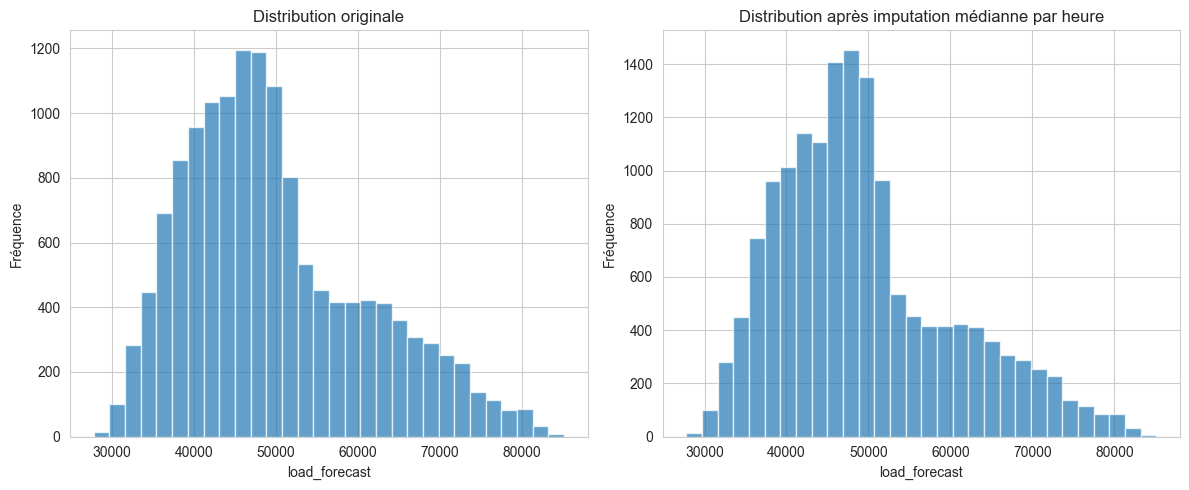

In [166]:
# Visualiser les distributions avant/après imputation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df[~missing_mask]['load_forecast'].hist(bins=30, alpha=0.7)
plt.title("Distribution originale")
plt.xlabel("load_forecast")
plt.ylabel("Fréquence")

plt.subplot(1, 2, 2)
df_imputed['load_forecast'].hist(bins=30, alpha=0.7)
plt.title(f"Distribution après imputation médianne par heure")
plt.xlabel("load_forecast")
plt.ylabel("Fréquence")

plt.tight_layout()

### wind_power_forecasts_average

In [167]:
df_sorted = df_imputed.sort_values('DELIVERY_START')


serie_complete = df_sorted['wind_power_forecasts_average'].dropna()

# Calculer la corrélation globale entre chaque point et son suivant
global_corr = np.corrcoef(serie_complete[:-1], serie_complete[1:])[0, 1]
print("Corrélation globale :", global_corr)

# Fonction pour calculer la corrélation locale (entre t-1 et t+1)
def calculate_local_correlation(data):
    # On utilise uniquement les indices où t-1 et t+1 existent
    x_vals = []
    y_vals = []
    for i in range(1, len(data) - 1):
        x_vals.append(data.iloc[i-1])
        y_vals.append(data.iloc[i+1])
    return np.corrcoef(x_vals, y_vals)[0, 1]

# Calculer la corrélation locale avant interpolation
local_corr_originale = calculate_local_correlation(serie_complete)
print("Corrélation locale originale :", local_corr_originale)

# Créer des copies pour les interpolations
df_linear = df_sorted.copy()
df_cubic = df_sorted.copy()

# Interpolation linéaire
df_linear['wind_power_forecasts_average'] = df_linear['wind_power_forecasts_average'].interpolate(method='linear')
df_linear['wind_power_forecasts_average'] = df_linear['wind_power_forecasts_average'].fillna(method='ffill').fillna(method='bfill')

# Interpolation cubique
df_cubic['wind_power_forecasts_average'] = df_cubic['wind_power_forecasts_average'].interpolate(method='cubic')
df_cubic['wind_power_forecasts_average'] = df_cubic['wind_power_forecasts_average'].fillna(method='ffill').fillna(method='bfill')

# Pour le calcul, recréer les séries sans NaN
serie_linear = df_linear['wind_power_forecasts_average']
serie_cubic = df_cubic['wind_power_forecasts_average']

# Calculer la corrélation globale après interpolation
global_corr_linear = np.corrcoef(serie_linear[:-1], serie_linear[1:])[0, 1]
global_corr_cubic  = np.corrcoef(serie_cubic[:-1], serie_cubic[1:])[0, 1]

# Calculer la corrélation locale après interpolation
local_corr_linear = calculate_local_correlation(serie_linear)
local_corr_cubic  = calculate_local_correlation(serie_cubic)

# Comparaison des corrélations
print("\nComparaison des corrélations :")
print(f"Corrélation globale - Originale : {global_corr}")
print(f"Corrélation locale - Originale  : {local_corr_originale}")

# Ajout des valeurs imputées (ici issues de l'interpolation cubique) dans df_imputed
df_imputed['wind_power_forecasts_average'] = (
    df_cubic)['wind_power_forecasts_average']

Corrélation globale : 0.9944075865461373
Corrélation locale originale : 0.9803714192035405

Comparaison des corrélations :
Corrélation globale - Originale : 0.9944075865461373
Corrélation locale - Originale  : 0.9803714192035405


C:\Users\tmont\AppData\Local\Temp\ipykernel_43860\3589865665.py:30: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_linear['wind_power_forecasts_average'] = df_linear['wind_power_forecasts_average'].fillna(method='ffill').fillna(method='bfill')
C:\Users\tmont\AppData\Local\Temp\ipykernel_43860\3589865665.py:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_cubic['wind_power_forecasts_average'] = df_cubic['wind_power_forecasts_average'].fillna(method='ffill').fillna(method='bfill')


### wind_power_forecasts_std

In [168]:
df_sorted = df_imputed.sort_values('DELIVERY_START')

# On s'assure de travailler sur la série sans NaN pour le calcul global
serie_complete = df_sorted['wind_power_forecasts_std'].dropna()

# Calculer la corrélation globale entre chaque point et son suivant
global_corr = np.corrcoef(serie_complete[:-1], serie_complete[1:])[0, 1]
print("Corrélation globale :", global_corr)


# Calculer la corrélation locale avant interpolation
local_corr_originale = calculate_local_correlation(serie_complete)
print("Corrélation locale originale :", local_corr_originale)

# Créer des copies pour les interpolations
df_linear = df_sorted.copy()
df_cubic = df_sorted.copy()

# Interpolation linéaire
df_linear['wind_power_forecasts_std'] = df_linear['wind_power_forecasts_std'].interpolate(method='linear')
df_linear['wind_power_forecasts_std'] = df_linear['wind_power_forecasts_std'].fillna(method='ffill').fillna(method='bfill')

# Interpolation cubique
df_cubic['wind_power_forecasts_std'] = df_cubic['wind_power_forecasts_std'].interpolate(method='cubic')
df_cubic['wind_power_forecasts_std'] = df_cubic['wind_power_forecasts_std'].fillna(method='ffill').fillna(method='bfill')

# Pour le calcul, recréer les séries sans NaN
serie_linear = df_linear['wind_power_forecasts_std']
serie_cubic = df_cubic['wind_power_forecasts_std']

# Calculer la corrélation globale après interpolation
global_corr_linear = np.corrcoef(serie_linear[:-1], serie_linear[1:])[0, 1]
global_corr_cubic  = np.corrcoef(serie_cubic[:-1], serie_cubic[1:])[0, 1]

# Calculer la corrélation locale après interpolation
local_corr_linear = calculate_local_correlation(serie_linear)
local_corr_cubic  = calculate_local_correlation(serie_cubic)


# Sélection de la méthode qui préserve le mieux la structure de corrélation
if abs(global_corr_linear - global_corr) < abs(global_corr_cubic - global_corr):
    df_imputed['wind_power_forecasts_std'] = df_linear['wind_power_forecasts_std']
else:
    df_imputed['wind_power_forecasts_std'] = df_cubic['wind_power_forecasts_std']
#le spline cibique revient avec de meilleurs résultats

Corrélation globale : 0.898685514865192
Corrélation locale originale : 0.7665478147450726


C:\Users\tmont\AppData\Local\Temp\ipykernel_43860\1879552614.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_linear['wind_power_forecasts_std'] = df_linear['wind_power_forecasts_std'].fillna(method='ffill').fillna(method='bfill')
C:\Users\tmont\AppData\Local\Temp\ipykernel_43860\1879552614.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_cubic['wind_power_forecasts_std'] = df_cubic['wind_power_forecasts_std'].fillna(method='ffill').fillna(method='bfill')


In [169]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15547 entries, 0 to 15546
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DELIVERY_START                 15547 non-null  object 
 1   load_forecast                  15547 non-null  float64
 2   coal_power_available           15546 non-null  float64
 3   gas_power_available            15546 non-null  float64
 4   nuclear_power_available        15546 non-null  float64
 5   wind_power_forecasts_average   15547 non-null  float64
 6   solar_power_forecasts_average  15499 non-null  float64
 7   wind_power_forecasts_std       15547 non-null  float64
 8   solar_power_forecasts_std      15499 non-null  float64
 9   predicted_spot_price           5252 non-null   float64
 10  data_source                    15547 non-null  object 
 11  hour                           15547 non-null  int64  
dtypes: float64(9), int64(1), object(2)
memory usag

### solar_power_forecasts_average

In [170]:
import pandas as pd
import numpy as np

# Copie du DataFrame trié
df_sorted = df_imputed.copy()
df_sorted['date_string'] = df_sorted['DELIVERY_START'].astype(str).str.split(' ').str[0]
df_sorted['hour'] = df_sorted['DELIVERY_START'].astype(str).str.split(' ').str[1].str.split(':').str[0].astype(int)

# Liste des dates où il manque des données
missing_dates = ['2023-02-19', '2023-02-20', '2023-04-26', '2023-04-27']

df_output = df_sorted.copy()

# Pour chaque date avec des données manquantes
for missing_date in missing_dates:
    # On prends une fenêtre de 3 jours avant et après
    window_size = 3
    date_range = []
    for i in range(-window_size, window_size + 1):
        if i == 0:  # Sauter la date manquante elle-même
            continue
        window_date = (pd.to_datetime(missing_date) + pd.Timedelta(days=i)).strftime('%Y-%m-%d')
        date_range.append(window_date)

    # Filtrer les dates de la fenêtre qui existent réellement dans le dataset
    existing_dates = df_sorted['date_string'].unique()
    date_range = [date for date in date_range if date in existing_dates]

    # Pour chaque heure, calculer la médiane des valeurs sur la fenêtre glissante
    for hour in range(24):
        # Extraction des données de la date manquante pour cette heure
        missing_rows = df_sorted[(df_sorted['date_string'] == missing_date) &
                               (df_sorted['hour'] == hour)]

        # Vérifier s'il y a des valeurs manquantes pour cette heure
        if missing_rows.empty or not missing_rows['solar_power_forecasts_average'].isna().any():
            continue

        # Récupérer toutes les valeurs pour cette heure spécifique dans la fenêtre
        hour_values = []
        for date in date_range:
            values = df_sorted[(df_sorted['date_string'] == date) &
                              (df_sorted['hour'] == hour)]['solar_power_forecasts_average'].values
            if len(values) > 0 and not pd.isna(values[0]):
                hour_values.append(values[0])

        # Si on n'a pas de valeurs dans la fenêtre, essayer d'élargir la fenêtre
        if not hour_values:
            extended_window = 7  # Essayer avec une fenêtre plus large
            for i in range(-extended_window, extended_window + 1):
                if i == 0:
                    continue
                window_date = (pd.to_datetime(missing_date) + pd.Timedelta(days=i)).strftime('%Y-%m-%d')
                if window_date in existing_dates:
                    values = df_sorted[(df_sorted['date_string'] == window_date) &
                                     (df_sorted['hour'] == hour)]['solar_power_forecasts_average'].values
                    if len(values) > 0 and not pd.isna(values[0]):
                        hour_values.append(values[0])

        # Calculer la médiane si on a au moins une valeur
        if hour_values:
            median_value = np.median(hour_values)

            # Appliquer la médiane aux valeurs manquantes pour cette heure et cette date
            for idx in missing_rows.index:
                if pd.isna(df_output.loc[idx, 'solar_power_forecasts_average']):
                    df_output.loc[idx, 'solar_power_forecasts_average'] = median_value

# Traitement spécial pour le 19 février 23h et le 26 avril 22-23h qui sont à cheval sur deux jours
# Identifier ces timestamps spécifiques
special_timestamps = ['2023-02-19 23:00:00', '2023-04-26 22:00:00', '2023-04-26 23:00:00']

for timestamp in special_timestamps:
    idx = df_sorted[df_sorted['DELIVERY_START'] == timestamp].index
    if len(idx) > 0 and pd.isna(df_output.loc[idx[0], 'solar_power_forecasts_average']):
        # Extraire l'heure du timestamp
        hour = int(timestamp.split(' ')[1].split(':')[0])

        # Mettre zéro comme production solaire nocturne
        df_output.loc[idx[0], 'solar_power_forecasts_average'] = 0

# Ajout de la colonne imputée dans le DataFrame original
df_imputed['solar_power_forecasts_average'] = df_output['solar_power_forecasts_average']

# Nettoyage final du DataFrame (suppression des colonnes temporaires)
df_imputed = df_output.drop(['date_string', 'hour'], axis=1).copy()

In [171]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15547 entries, 0 to 15546
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DELIVERY_START                 15547 non-null  object 
 1   load_forecast                  15547 non-null  float64
 2   coal_power_available           15546 non-null  float64
 3   gas_power_available            15546 non-null  float64
 4   nuclear_power_available        15546 non-null  float64
 5   wind_power_forecasts_average   15547 non-null  float64
 6   solar_power_forecasts_average  15547 non-null  float64
 7   wind_power_forecasts_std       15547 non-null  float64
 8   solar_power_forecasts_std      15499 non-null  float64
 9   predicted_spot_price           5252 non-null   float64
 10  data_source                    15547 non-null  object 
dtypes: float64(9), object(2)
memory usage: 1.3+ MB


### solar_power_forecasts_std

In [172]:
import pandas as pd
import numpy as np

# Préparation des données
df_sorted = df_imputed.copy()
df_sorted['date_string'] = df_sorted['DELIVERY_START'].astype(str).str.split(' ').str[0]
df_sorted['hour'] = df_sorted['DELIVERY_START'].astype(str).str.split(' ').str[1].str.split(':').str[0].astype(int)

# Copie du DataFrame pour l'imputation
df_output = df_sorted.copy()

feb20_data = df_sorted[df_sorted['date_string'] == '2023-02-20']
hour_values = {}

# Récupérer les valeurs par heure du 20 février
for _, row in feb20_data.iterrows():
    hour = row['hour']
    value = row['solar_power_forecasts_std']
    if not pd.isna(value):
        hour_values[hour] = value

# Imputer les valeurs manquantes en utilisant le modèle du 20 février
for idx, row in df_sorted.iterrows():
    if pd.isna(row['solar_power_forecasts_std']):
        hour = row['hour']
        if hour in hour_values:
            df_output.loc[idx, 'solar_power_forecasts_std'] = hour_values[hour]
        else:
            # Pour les heures sans référence, mettre 0 (raisonnable pour l'énergie solaire la nuit)
            df_output.loc[idx, 'solar_power_forecasts_std'] = 0

# Ajout de la colonne imputée dans le DataFrame original
df_imputed['solar_power_forecasts_std'] = df_output['solar_power_forecasts_std']

# Nettoyage final du DataFrame
df_imputed = df_output.drop(['date_string', 'hour'], axis=1).copy()

### coal_power_available/gas_power_available/nuclear_power_available

In [173]:
columns_to_ffill = ['coal_power_available', 'gas_power_available', 'nuclear_power_available']

# Remplir les valeurs manquantes par la valeur précédente
df_imputed[columns_to_ffill] = df_imputed[columns_to_ffill].ffill()

In [174]:
df_imputed.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15547 entries, 0 to 15546
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DELIVERY_START                 15547 non-null  object 
 1   load_forecast                  15547 non-null  float64
 2   coal_power_available           15547 non-null  float64
 3   gas_power_available            15547 non-null  float64
 4   nuclear_power_available        15547 non-null  float64
 5   wind_power_forecasts_average   15547 non-null  float64
 6   solar_power_forecasts_average  15547 non-null  float64
 7   wind_power_forecasts_std       15547 non-null  float64
 8   solar_power_forecasts_std      15547 non-null  float64
 9   predicted_spot_price           5252 non-null   float64
 10  data_source                    15547 non-null  object 
dtypes: float64(9), object(2)
memory usage: 1.3+ MB


### predicted_spot_price

In [175]:
# On enlève la vairables car il y a plus de 80 % manquantes, voir le notebook Elastic_net_predicted_spot_price pour plus de détails
df_imputed =df_imputed.drop(['predicted_spot_price'], axis = 1)

## Ajout de variables

### Ajout d'une variable mensuelle hot one encoding

In [176]:
print(df_imputed['DELIVERY_START'].dtype)


object


In [177]:
month_names = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}

df_imputed['month_str'] = df_imputed['DELIVERY_START'].astype(str).str.split('-').str[1].astype(int)

# Créer les variables one-hot directement
for month_num, month_name in month_names.items():
    df_imputed[month_name] = (df_imputed['month_str'] == month_num).astype(int)

# Supprimer la colonne temporaire
df_imputed.drop('month_str', axis=1, inplace=True)

### Ajout d'une variable week-end

In [178]:
df_imputed['DELIVERY_START'] = pd.to_datetime(df_imputed['DELIVERY_START'], utc=True)
df_imputed['is_weekend'] = df_imputed['DELIVERY_START'].dt.dayofweek.apply(lambda x: 1 if x in [5, 6] else 0)

### Ajout d'une variable jour/nuit

In [179]:
df_imputed['is_day'] = df_imputed['DELIVERY_START'].dt.hour.apply(lambda x: 1 if 8 <= x <= 20 else 0)

### Ratios pour chaque énergies

In [180]:
df_imputed['solar_ratio'] = df_imputed['solar_power_forecasts_average'] / df_imputed['load_forecast']
df_imputed['wind_ratio'] = df_imputed['wind_power_forecasts_average'] / df_imputed['load_forecast']
df_imputed['coal_ratio'] = df_imputed['coal_power_available'] / df_imputed['load_forecast']
df_imputed['gas_ratio'] = df_imputed['gas_power_available'] / df_imputed['load_forecast']
df_imputed['nuclear_ratio'] = df_imputed['nuclear_power_available'] / df_imputed['load_forecast']

### Ratio fossile/non-fossile + contrôle/non-contrôlable

In [181]:
df_imputed['fossil_ratio'] = (df_imputed['coal_power_available'] + df_imputed['gas_power_available']) / df_imputed['load_forecast']
df_imputed['green_ratio'] = (df_imputed['wind_power_forecasts_average'] + df_imputed['solar_power_forecasts_average']) / df_imputed['load_forecast']
df_imputed['nuclear_ratio'] = df_imputed['nuclear_power_available'] / df_imputed['load_forecast']
df_imputed['controlable_ratio'] = (df_imputed['coal_power_available'] + df_imputed['gas_power_available'] + df_imputed['nuclear_power_available']) / df_imputed['load_forecast']

### Demande-Offre

In [182]:
df_imputed['all_offer'] = df_imputed['coal_power_available'] + df_imputed['gas_power_available'] + df_imputed['nuclear_power_available'] + df_imputed['wind_power_forecasts_average'] + df_imputed['solar_power_forecasts_average']
df_imputed['offer_minus_load'] = df_imputed['all_offer'] - df_imputed['load_forecast']

### Variable lag

In [183]:
# Concaténation des données train et test pour y
df_Y = pd.concat([Y_train_full, y_test_full], axis=0, ignore_index=True)

df_imputed['DELIVERY_START'] = pd.to_datetime(df_imputed['DELIVERY_START'], utc=True)
df_Y['DELIVERY_START'] = pd.to_datetime(df_Y['DELIVERY_START'], utc=True)

df_Y = df_Y.set_index('DELIVERY_START')
df_imputed = df_imputed.set_index('DELIVERY_START')

# Concaténation de df_imputed avec la colonne spot_id_delta de df_Y
df_imputed = pd.concat([df_imputed, df_Y[['spot_id_delta']]], axis=1)

# Création des colonnes de lag
for i in range(1, 19):
    df_imputed[f'spot_id_delta_lag_{i}'] = df_imputed['spot_id_delta'].shift(i)

# Suppression de la colonne spot_id_delta originale
df_imputed = df_imputed.drop(columns=['spot_id_delta'])

df_imputed = df_imputed.iloc[18:].reset_index()

### Configurations de marché

In [184]:
'''
features = [
    'load_forecast', 'coal_power_available',
    'gas_power_available', 'nuclear_power_available',
    'wind_power_forecasts_average', 'solar_power_forecasts_average',
    'wind_power_forecasts_std', 'solar_power_forecasts_std'
]

X = df_imputed[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca_full = PCA()
pca_full.fit(X_scaled)

var_ratio = pca_full.explained_variance_ratio_
cum_var = np.cumsum(var_ratio)

#Choisir le nombre de composantes qui explique au moins 80% de la variance
n_components = np.where(cum_var >= 0.8)[0][0] + 1
print(f"Nombre de composantes retenu: {n_components} (explique {cum_var[n_components-1]*100:.1f}% de la variance)")

#Appliquer la PCA avec le bon nombre de composantes
pca = PCA(n_components=n_components)
components = pca.fit_transform(X_scaled)

for i in range(n_components):
    df_imputed[f'market_pc{i+1}'] = components[:, i]
    print(f"Ajout de la composante {i+1} qui explique {var_ratio[i]*100:.1f}% de la variance")
'''

'\nfeatures = [\n    \'load_forecast\', \'coal_power_available\',\n    \'gas_power_available\', \'nuclear_power_available\',\n    \'wind_power_forecasts_average\', \'solar_power_forecasts_average\',\n    \'wind_power_forecasts_std\', \'solar_power_forecasts_std\'\n]\n\nX = df_imputed[features].values\nscaler = StandardScaler()\nX_scaled = scaler.fit_transform(X)\n\npca_full = PCA()\npca_full.fit(X_scaled)\n\nvar_ratio = pca_full.explained_variance_ratio_\ncum_var = np.cumsum(var_ratio)\n\n#Choisir le nombre de composantes qui explique au moins 80% de la variance\nn_components = np.where(cum_var >= 0.8)[0][0] + 1\nprint(f"Nombre de composantes retenu: {n_components} (explique {cum_var[n_components-1]*100:.1f}% de la variance)")\n\n#Appliquer la PCA avec le bon nombre de composantes\npca = PCA(n_components=n_components)\ncomponents = pca.fit_transform(X_scaled)\n\nfor i in range(n_components):\n    df_imputed[f\'market_pc{i+1}\'] = components[:, i]\n    print(f"Ajout de la composante {i+

In [185]:
df_imputed.columns

Index(['DELIVERY_START', 'load_forecast', 'coal_power_available',
       'gas_power_available', 'nuclear_power_available',
       'wind_power_forecasts_average', 'solar_power_forecasts_average',
       'wind_power_forecasts_std', 'solar_power_forecasts_std', 'data_source',
       'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
       'Nov', 'Dec', 'is_weekend', 'is_day', 'solar_ratio', 'wind_ratio',
       'coal_ratio', 'gas_ratio', 'nuclear_ratio', 'fossil_ratio',
       'green_ratio', 'controlable_ratio', 'all_offer', 'offer_minus_load',
       'spot_id_delta_lag_1', 'spot_id_delta_lag_2', 'spot_id_delta_lag_3',
       'spot_id_delta_lag_4', 'spot_id_delta_lag_5', 'spot_id_delta_lag_6',
       'spot_id_delta_lag_7', 'spot_id_delta_lag_8', 'spot_id_delta_lag_9',
       'spot_id_delta_lag_10', 'spot_id_delta_lag_11', 'spot_id_delta_lag_12',
       'spot_id_delta_lag_13', 'spot_id_delta_lag_14', 'spot_id_delta_lag_15',
       'spot_id_delta_lag_16', 'spot_id_delta_

## Matrice de corréaltion des Y et X

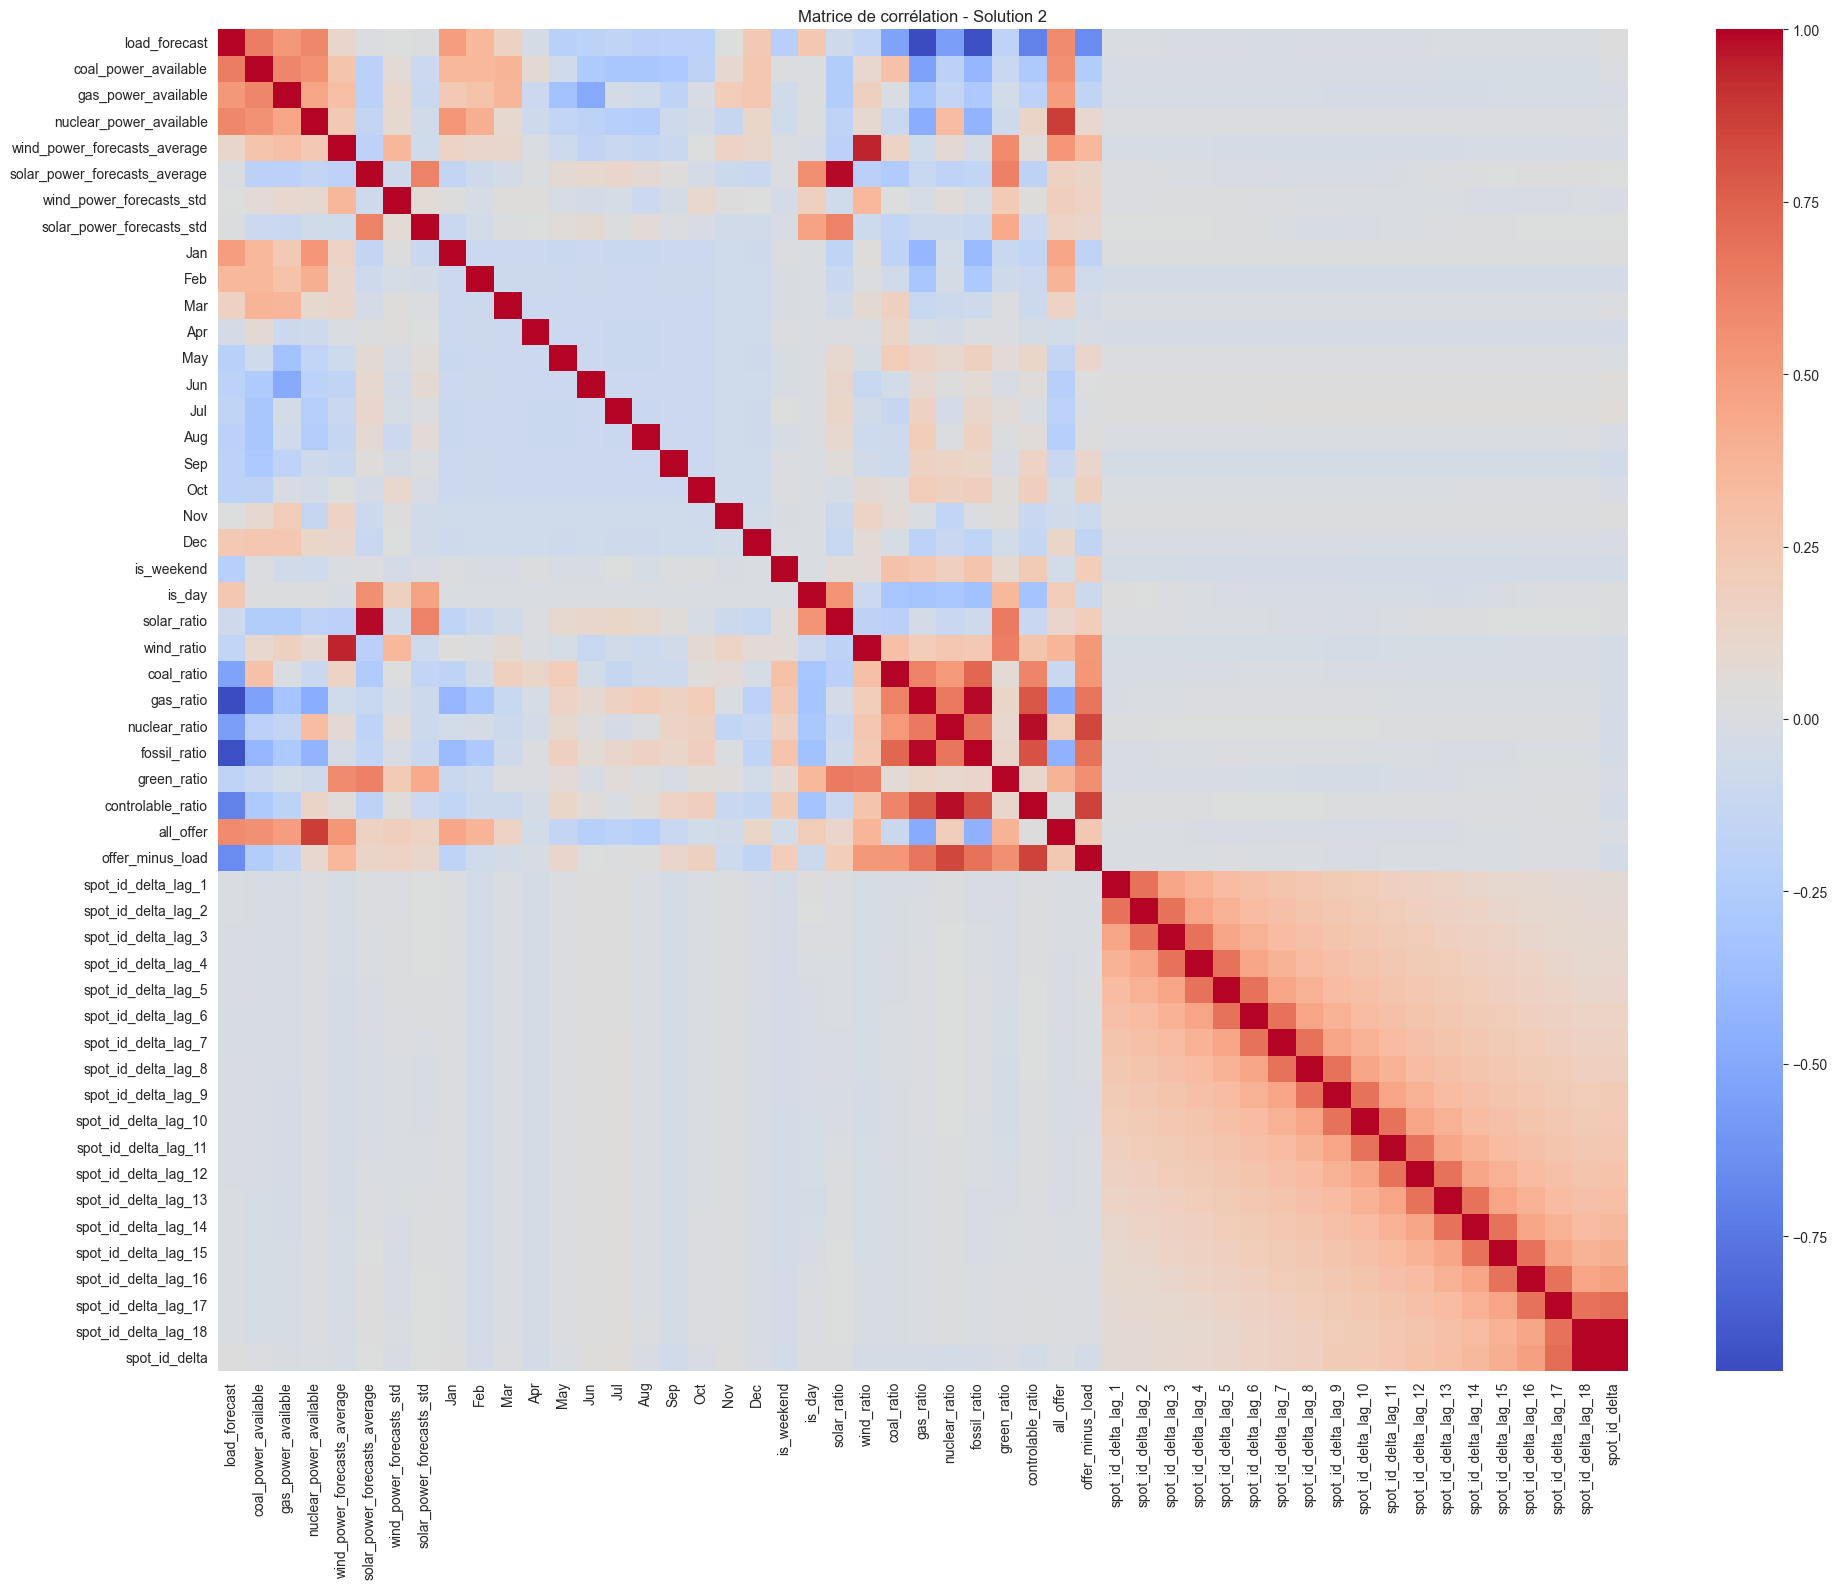

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_imputed_reset = df_imputed.reset_index(drop=True)
Y_train_reset = Y_train_full.reset_index(drop=True)

# Concaténer horizontalement
df_merged = pd.concat([df_imputed_reset, Y_train_reset], axis=1)

# Matrice de corrélation
correlation_matrix = df_merged.select_dtypes(include=[np.number]).corr()

# Visualiser
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Matrice de corrélation - Solution 2')
plt.tight_layout()
plt.show()

## V de Cramer


In [187]:
df_imputed.columns

Index(['DELIVERY_START', 'load_forecast', 'coal_power_available',
       'gas_power_available', 'nuclear_power_available',
       'wind_power_forecasts_average', 'solar_power_forecasts_average',
       'wind_power_forecasts_std', 'solar_power_forecasts_std', 'data_source',
       'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
       'Nov', 'Dec', 'is_weekend', 'is_day', 'solar_ratio', 'wind_ratio',
       'coal_ratio', 'gas_ratio', 'nuclear_ratio', 'fossil_ratio',
       'green_ratio', 'controlable_ratio', 'all_offer', 'offer_minus_load',
       'spot_id_delta_lag_1', 'spot_id_delta_lag_2', 'spot_id_delta_lag_3',
       'spot_id_delta_lag_4', 'spot_id_delta_lag_5', 'spot_id_delta_lag_6',
       'spot_id_delta_lag_7', 'spot_id_delta_lag_8', 'spot_id_delta_lag_9',
       'spot_id_delta_lag_10', 'spot_id_delta_lag_11', 'spot_id_delta_lag_12',
       'spot_id_delta_lag_13', 'spot_id_delta_lag_14', 'spot_id_delta_lag_15',
       'spot_id_delta_lag_16', 'spot_id_delta_

In [188]:
cat_columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
       'Nov', 'Dec', 'is_weekend', 'is_day']

In [189]:
v_matrix = pd.DataFrame(index=cat_columns, columns=cat_columns)
# Calcul du V de Cramer pour chaque paire de variables catégorielles
for i in cat_columns:
    for j in cat_columns:
        if i == j:
            v_matrix.loc[i, j] = 1.0
        else:
            # Création du tableau de contingence
            contingency = pd.crosstab(df_imputed[i], df_imputed[j])

            # Calcul du chi2
            chi2, p, dof, expected = chi2_contingency(contingency)

            # Calcul du V de Cramer
            n = contingency.sum().sum()
            phi2 = chi2/n
            r, k = contingency.shape
            v_matrix.loc[i, j] = np.sqrt(phi2 / min(k-1, r-1))

# Affichage de la matrice des V de Cramer
print("\nMatrice des V de Cramer :")
print(v_matrix)


Matrice des V de Cramer :
                 Jan       Feb       Mar       Apr       May       Jun  \
Jan              1.0  0.096484  0.100965  0.101606   0.10379  0.101005   
Feb         0.096484       1.0  0.093642  0.094237  0.096265  0.093679   
Mar         0.100965  0.093642       1.0  0.098615  0.100735  0.098031   
Apr         0.101606  0.094237  0.098615       1.0  0.101375  0.098654   
May          0.10379  0.096265  0.100735  0.101375       1.0  0.100775   
Jun         0.101005  0.093679  0.098031  0.098654  0.100775       1.0   
Jul         0.104812  0.097214  0.101728  0.102374  0.104574  0.101768   
Aug         0.104812  0.097214  0.101728  0.102374  0.104574  0.101768   
Sep         0.100039  0.092782  0.097093   0.09771  0.099811  0.097132   
Oct         0.098088  0.090971  0.095199  0.095804  0.097865  0.095237   
Nov         0.070722  0.065559  0.068627  0.069065   0.07056  0.068654   
Dec         0.071967  0.066715  0.069835  0.070282  0.071802  0.069863   
is_weekend 

In [190]:
# Conversion en DataFrame (si ce n'est pas déjà le cas)
if not isinstance(v_matrix, pd.DataFrame):

    v_matrix = pd.read_csv(io.StringIO(v_matrix), header=None)
    v_matrix = v_matrix.set_index(0)

# Conversion en nombres flottants
v_matrix = v_matrix.astype(float)

# Vérification du type
print(v_matrix.dtypes)

Jan           float64
Feb           float64
Mar           float64
Apr           float64
May           float64
Jun           float64
Jul           float64
Aug           float64
Sep           float64
Oct           float64
Nov           float64
Dec           float64
is_weekend    float64
is_day        float64
dtype: object


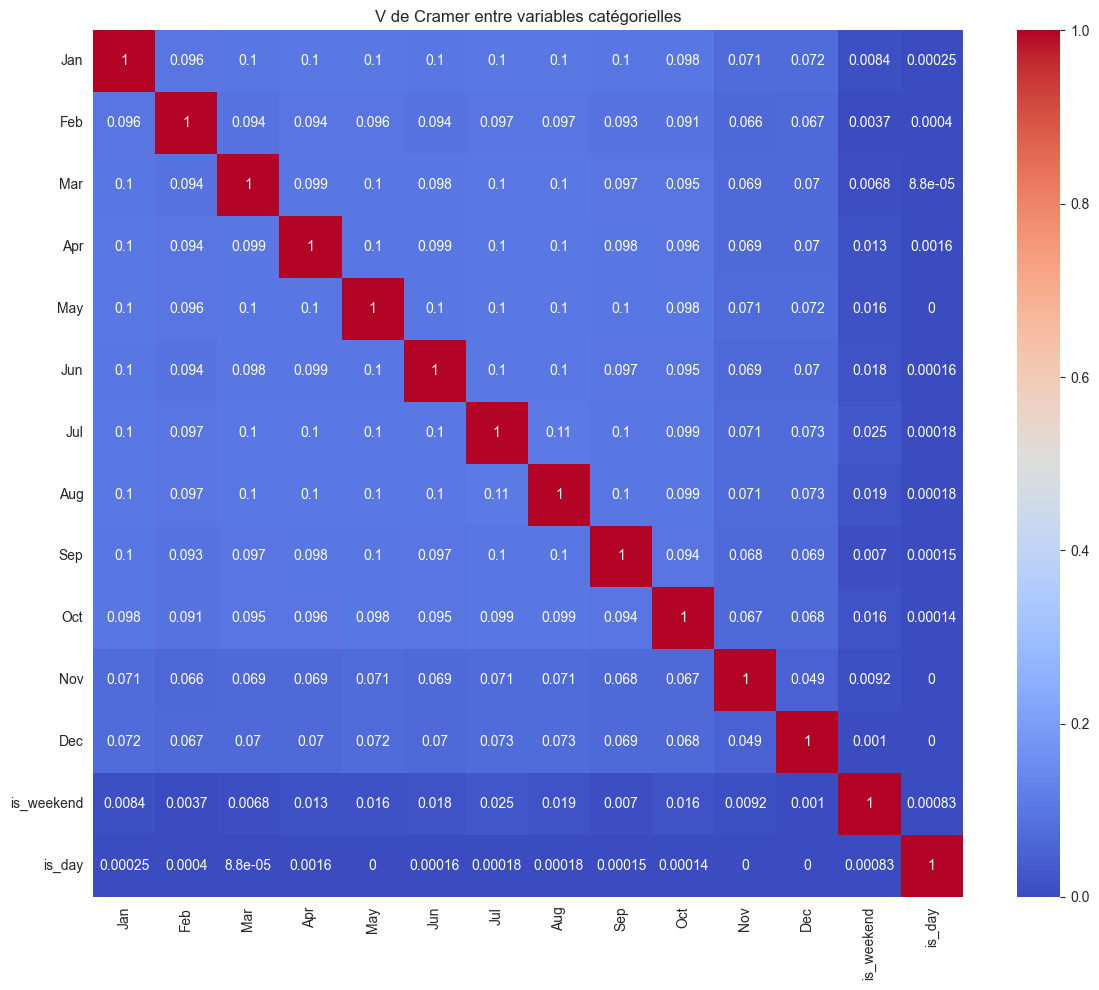

In [191]:
# Visualisation avec une heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(v_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("V de Cramer entre variables catégorielles")
plt.tight_layout()
plt.show()

### Normalisation des df

In [194]:
# Liste des variables à exclure de la normalisation
variables_a_exclure = ['DELIVERY_START', 'data_source',
                       'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec',
                       'is_weekend', 'is_day'
                       ]

# Identifier les colonnes numériques
colonnes_numeriques = [col for col in df_imputed.columns if col not in variables_a_exclure]

# Normaliser uniquement les colonnes numériques avec StandardScaler
df_imputed[colonnes_numeriques] = StandardScaler().fit_transform(df_imputed[colonnes_numeriques])

## Séparation des df

In [195]:
df_imputed.head()

,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nuclear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,data_source,...,spot_id_delta_lag_9,spot_id_delta_lag_10,spot_id_delta_lag_11,spot_id_delta_lag_12,spot_id_delta_lag_13,spot_id_delta_lag_14,spot_id_delta_lag_15,spot_id_delta_lag_16,spot_id_delta_lag_17,spot_id_delta_lag_18
0,2022-01-01 19:00:00+00:00,0.420998,1.418625,0.287611,1.285499,0.146087,-0.74053,0.512179,-0.588654,train,...,-0.550178,-0.452668,-0.614957,-0.154990,-0.098261,-0.062696,-0.008653,-0.129424,-0.461581,-1.214280
1,2022-01-01 20:00:00+00:00,0.249349,1.418625,0.287611,1.285499,0.188259,-0.74053,0.536946,-0.588654,train,...,-0.827843,-0.550142,-0.452642,-0.614969,-0.155019,-0.098235,-0.062661,-0.008615,-0.129350,-0.461483
2,2022-01-01 21:00:00+00:00,0.321520,1.418625,0.287611,1.285499,0.243114,-0.74053,0.881371,-0.588654,train,...,-0.923618,-0.827804,-0.550116,-0.452654,-0.615001,-0.154992,-0.098200,-0.062623,-0.008540,-0.129268
3,2022-01-01 22:00:00+00:00,0.383194,1.418625,0.287611,1.285499,0.316676,-0.74053,1.406182,-0.588654,train,...,-1.122089,-0.923579,-0.827775,-0.550127,-0.452685,-0.614976,-0.154958,-0.098163,-0.062549,-0.008464
4,2022-01-01 23:00:00+00:00,0.298485,-0.911772,0.287611,1.146007,0.414654,-0.74053,-0.213277,-0.588654,train,...,-0.945988,-1.122049,-0.923549,-0.827788,-0.550159,-0.452660,-0.614947,-0.154921,-0.098089,-0.062470


In [196]:
df_imputed['DELIVERY_START'] = pd.to_datetime(df_imputed['DELIVERY_START']).dt.tz_localize(None)

In [197]:
df_imputed_train = df_imputed[df_imputed['data_source'] == 'train'].copy()
df_imputed_test = df_imputed[df_imputed['data_source'] == 'test'].copy()

df_imputed_train = df_imputed_train.drop('data_source', axis=1)
df_imputed_test = df_imputed_test.drop('data_source', axis=1)

In [199]:
df_imputed_test.to_csv('df_imputed_test.csv', index=False)
df_imputed_train.to_csv('df_imputed_train.csv', index=False)